# Cognition & Computation project

In [106]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
import tqdm
from DBN import DBN
import torch.nn.functional as functional
import scipy.cluster as cluster

## Data

In [107]:
def get_data():
    mnist_train = tv.datasets.MNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

    mnist_test = tv.datasets.MNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))
    mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
    mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

    return mnist_train, mnist_test


In [108]:
def move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [109]:
def get_mask(label, targets):  # we use this function to filter by class
    # labels = mnist_targets_train.numpy()
    return targets.numpy() == label

In [110]:
mnist_train, mnist_test = get_data()

data_train = mnist_train.data
targets_train = mnist_train.targets

data_test = mnist_test.data
targets_test = mnist_test.targets


In [111]:
class DBNShallowParams:
    visible_units=28*28
    hidden_units=[500]
    k=1
    learning_rate=0.1
    learning_rate_decay=False
    initial_momentum=0.5
    final_momentum=0.9
    weight_decay=0.0002
    xavier_init=False
    increase_to_cd_k=False
    use_gpu=True

class DBNDeepParams:
    visible_units=28*28
    hidden_units=[500, 500]
    k=1
    learning_rate=0.1
    learning_rate_decay=False
    initial_momentum=0.5
    final_momentum=0.9
    weight_decay=0.0002
    xavier_init=False
    increase_to_cd_k=False
    use_gpu=True

class TrainParameters:
    epochs = 40  # 50
    batch_size = 125  # 100
    class_num = 10

## Model prepare & train

In [112]:
dbn_shallow = DBN(
    visible_units = DBNShallowParams.visible_units,
    hidden_units = DBNShallowParams.hidden_units,
    k = DBNShallowParams.k,
    learning_rate = DBNShallowParams.learning_rate,
    learning_rate_decay = DBNShallowParams.learning_rate_decay,
    initial_momentum = DBNShallowParams.initial_momentum,
    final_momentum = DBNShallowParams.final_momentum,
    weight_decay = DBNShallowParams.weight_decay,
    xavier_init = DBNShallowParams.xavier_init,
    increase_to_cd_k = DBNShallowParams.increase_to_cd_k,
    use_gpu = DBNShallowParams.use_gpu
)

dbn_deep = DBN(
    visible_units = DBNDeepParams.visible_units,
    hidden_units = DBNDeepParams.hidden_units,
    k = DBNDeepParams.k,
    learning_rate = DBNDeepParams.learning_rate,
    learning_rate_decay = DBNDeepParams.learning_rate_decay,
    initial_momentum = DBNDeepParams.initial_momentum,
    final_momentum = DBNDeepParams.final_momentum,
    weight_decay = DBNDeepParams.weight_decay,
    xavier_init = DBNDeepParams.xavier_init,
    increase_to_cd_k = DBNDeepParams.increase_to_cd_k,
    use_gpu = DBNDeepParams.use_gpu
)


In [113]:
def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)

In [114]:
class DBNAggreg:
    def __init__(self, dbn_model, n_classes):
        self.dbn_model = dbn_model
        self.n_classes = n_classes
        
        self.hidden_representations_train = []
        self.hidden_representations_test = []
        
        self.learned_weights = []
        self.weight_products = []
        self.processed_weight_products = []

        self.label_to_mean_hidden_representations = []
        self.mean_hidden_representation_matrices = []

        self.attached_perceptron = None

    def n_layers(self):
        return len(self.dbn_model.rbm_layers)
    
    def train_dbn(self, data, targets, train_parameters):
        self.dbn_model.train_static(
            data,
            targets,
            train_parameters.epochs,
            train_parameters.batch_size
        )
        move_parameters_to_cpu(self.dbn_model)

    def get_layer_repr(self, data, n_layer):
        flattened_input = data.view((data.shape[0], -1)).type(torch.FloatTensor)
        hidden_repr, _ = self.dbn_model.rbm_layers[n_layer].to_hidden(flattened_input)
        return hidden_repr

    def get_hidden_representations(self, data):
        res = []
        print(f'Total: {self.n_layers()} hidden layers')
        for i in range(self.n_layers()):
            if i == 0:
                repr = self.get_layer_repr(data, n_layer = i)
            else:
                input = res[i - 1]  # Prev hidden representation layer
                repr = self.get_layer_repr(input, n_layer = i)
            res.append(repr)
        return res
    
    def calc_train_representations(self, data):
        self.hidden_representations_train = self.get_hidden_representations(data)
    
    def calc_test_representations(self, data):
        self.hidden_representations_test = self.get_hidden_representations(data)

    def get_learned_weights(self):
        self.learned_weights = []
        for i in range(self.n_layers()):
            self.learned_weights.append(self.dbn_model.rbm_layers[i].W.numpy())

    def get_weight_products(self):
        self.weight_products = []
        for i, w in enumerate(self.learned_weights):
            if i == 0:
                self.weight_products.append(w)
            else:
                cur_w = self.learned_weights[0]
                for j in range(1, i + 1):
                    cur_w = cur_w @ self.learned_weights[j]
                self.weight_products.append(cur_w)
    
    def get_processed_weight_products(self):
        self.processed_weight_products = [apply_threshold(w) for w in self.weight_products]


    def get_label_to_mean_hidden_representations(self, targets):
        self.label_to_mean_hidden_representations = [
            self.get_label_to_mean_hidden_representation(h, targets)
            for h in self.hidden_representations_train
        ]
    
    def get_mean_hidden_representation_matrices(self):
        self.mean_hidden_representation_matrices = [
            self.get_hidden_reprs_matrix(l_to_mean)
            for l_to_mean in self.label_to_mean_hidden_representations
        ]

    def get_label_to_mean_hidden_representation(self, hidden_repr, targets):
        hidden_representation_np = hidden_repr.numpy()
        return {
            label: hidden_representation_np[get_mask(label, targets)].mean(axis=0)
            for label in range(self.n_classes)
        }
    
    def get_hidden_reprs_matrix(self, l_to_mean):
        return np.concatenate(
            [np.expand_dims(l_to_mean[label], axis=0)
            for label in range(self.n_classes)]
        )
    
    def attach_perceptron(self, n_layer):
        rbm_layer_size = self.dbn_model.rbm_layers[n_layer].W.shape[1]
        self.attached_perceptron = Perceptron(rbm_layer_size, class_num = self.n_classes)

    def train_perceptron(self, n_layer, targets, epochs):
        _train(
            model = self.attached_perceptron, 
            input = self.hidden_representations_train[n_layer], 
            targets = targets, 
            epochs = epochs
        )

    def perceptron_accuracy(self, n_layer, targets):
        test_repr = self.hidden_representations_test[n_layer]
        predictions = self.attached_perceptron(test_repr)
        return compute_accuracy(predictions, targets)

In [115]:
model_deep = DBNAggreg(
    dbn_model = dbn_deep,
    n_classes = 10
)

model_shallow = DBNAggreg(
    dbn_model = dbn_shallow,
    n_classes = 10
)

In [116]:
model_deep.train_dbn(
    data = data_train,
    targets = targets_train,
    train_parameters = TrainParameters
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2230   |0.0613   |318.6574 |13.6013   |
|20    |1.1697   |0.0592   |305.8097 |12.8704   |
|30    |1.1486   |0.0559   |298.6829 |11.2340   |
|40    |1.1376   |0.0577   |294.2854 |12.3290   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6001   |0.0513   |263.1419 |10.0566   |
|20    |1.5434   |0.0497   |256.1768 |10.9423   |
|30    |1.5346   |0.0502   |256.9385 |11.2169   |
|40    |1.5248   |0.0505   |254.9751 |11.1766   |


In [117]:
model_shallow.train_dbn(
    data = data_train,
    targets = targets_train,
    train_parameters = TrainParameters
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2255   |0.0614   |320.0411 |12.6979   |
|20    |1.1655   |0.0588   |303.2002 |11.4986   |
|30    |1.1488   |0.0582   |298.6320 |11.8544   |
|40    |1.1363   |0.0558   |292.7967 |11.0468   |


## Prepare hidden representations

In [118]:
def get_layer_repr(data, dbn_model, n_layer):
    flattened_input = data.view((data.shape[0], -1)).type(torch.FloatTensor)
    hidden_repr, _ = dbn_model.rbm_layers[n_layer].to_hidden(flattened_input)
    return hidden_repr

In [120]:
def perform_calculations(model):
    model.calc_train_representations(data_train)
    model.calc_test_representations(data_test)
    model.get_learned_weights()
    model.get_weight_products()
    model.get_processed_weight_products()
    
    model.get_label_to_mean_hidden_representations(targets = targets_train)
    model.get_mean_hidden_representation_matrices()
    
perform_calculations(model_deep)
perform_calculations(model_shallow)

Total: 2 hidden layers
Total: 2 hidden layers
Total: 1 hidden layers
Total: 1 hidden layers


In [89]:
def plot_layer_receptive_fields(weights):
  num_subplots = 64
  n_rows_cols = int(math.sqrt(num_subplots))
  _, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[:, i].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

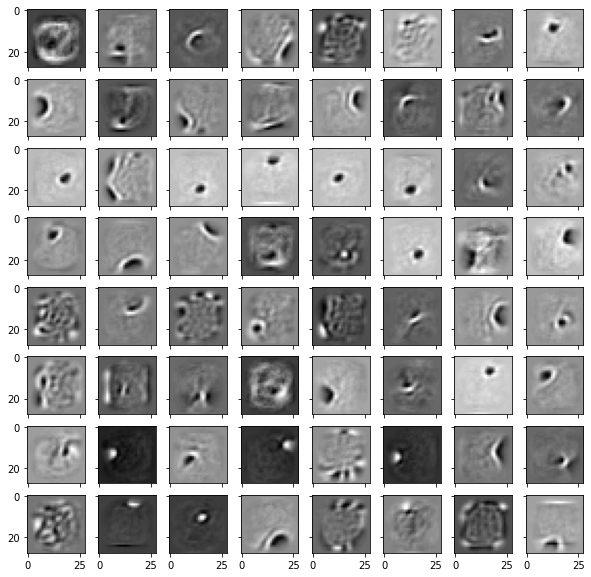

In [90]:
plot_layer_receptive_fields(
    model_deep.processed_weight_products[0]
)

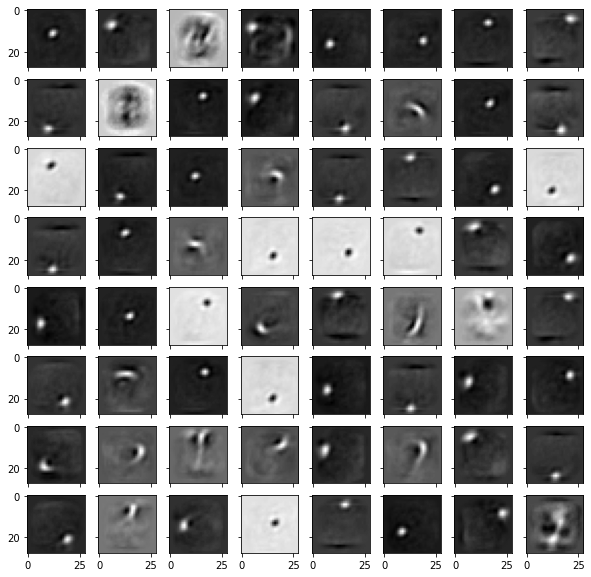

In [91]:
plot_layer_receptive_fields(
    model_deep.processed_weight_products[1]
)

## Clustering internal representations

In [121]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  _ = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

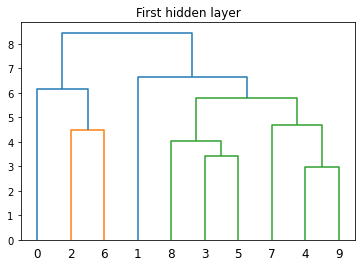

In [122]:
plot_dendrogram(
    model_deep.mean_hidden_representation_matrices[0], "First hidden layer"
)

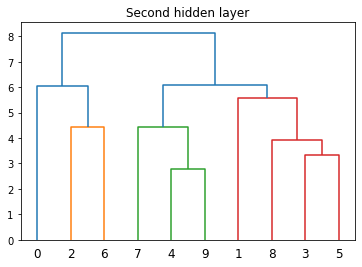

In [123]:
plot_dendrogram(
    model_deep.mean_hidden_representation_matrices[1], 'Second hidden layer'
)

## Linear readouts

Let's first compute the hidden representations:

In [124]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size, class_num):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, class_num)

  def forward(self, x):
    return self.linear(x)

### First hidden layer representations

Let's train the readout layer:

In [125]:
def _train(model, input, targets, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(input).squeeze()
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [126]:
model_deep.attach_perceptron(
    n_layer = 0
)

model_deep.train_perceptron(
    n_layer = 0,  # from which layer to take hidden repr
    targets = targets_train,
    epochs = 1500
)

epoch 0/1500, loss = 2.293914
epoch 100/1500, loss = 0.657637
epoch 200/1500, loss = 0.496096
epoch 300/1500, loss = 0.430938
epoch 400/1500, loss = 0.393785
epoch 500/1500, loss = 0.368982
epoch 600/1500, loss = 0.350850
epoch 700/1500, loss = 0.336792
epoch 800/1500, loss = 0.325435
epoch 900/1500, loss = 0.315976
epoch 1000/1500, loss = 0.307914
epoch 1100/1500, loss = 0.300916
epoch 1200/1500, loss = 0.294751
epoch 1300/1500, loss = 0.289255
epoch 1400/1500, loss = 0.284304


In [128]:
model_shallow.attach_perceptron(
    n_layer = 0
)

model_shallow.train_perceptron(
    n_layer = 0,
    targets = targets_train,
    epochs = 1500
)

epoch 0/1500, loss = 2.400908
epoch 100/1500, loss = 0.665957
epoch 200/1500, loss = 0.499073
epoch 300/1500, loss = 0.432347
epoch 400/1500, loss = 0.394507
epoch 500/1500, loss = 0.369333
epoch 600/1500, loss = 0.350977
epoch 700/1500, loss = 0.336770
epoch 800/1500, loss = 0.325307
epoch 900/1500, loss = 0.315770
epoch 1000/1500, loss = 0.307647
epoch 1100/1500, loss = 0.300600
epoch 1200/1500, loss = 0.294394
epoch 1300/1500, loss = 0.288862
epoch 1400/1500, loss = 0.283881


Let's test it on the hold-out dataset:

In [130]:
def compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [131]:
model_deep.perceptron_accuracy(n_layer = 0, targets = targets_test)

0.9275000095367432

In [132]:
model_shallow.perceptron_accuracy(n_layer = 0, targets = targets_test)

0.9269999861717224

## Comparison with a feedforward model

Let's now train a simple feedforward neural network with the same structure as the RBM, i.e. with one hidden layer with `500` units.

We want to compare a network that is trained end-to-end to solve a classification task with a simple classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [133]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, first_hidden_layer_size, output_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(input_size, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, output_size)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [134]:
ffnn = Feedforward(
    input_size = 784,
    first_hidden_layer_size = 500,
    output_size = 10
)

We choose the number of epochs to match the training time of the RBM and the readout layer combined.

In [135]:
_train(
    ffnn, 
    data_train,
    targets = targets_train, 
    epochs=120
)

epoch 0/120, loss = 2.314374
epoch 10/120, loss = 2.193951
epoch 20/120, loss = 2.067692
epoch 30/120, loss = 1.920729
epoch 40/120, loss = 1.752414
epoch 50/120, loss = 1.573726
epoch 60/120, loss = 1.400839
epoch 70/120, loss = 1.246715
epoch 80/120, loss = 1.116866
epoch 90/120, loss = 1.010662
epoch 100/120, loss = 0.924616
epoch 110/120, loss = 0.854693


In [136]:
predictions_ffnn = ffnn(data_test)

In [137]:
compute_accuracy(predictions_ffnn, targets_test)

0.8424999713897705

## Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the RBM are robust to noise.

In [138]:
def inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape)/6.6 + .6
  probability_tensor = torch.ones(data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return data - mask_tensor * data + mask_tensor * random_gaussian_tensor

Let's see what a noisy image looks like:

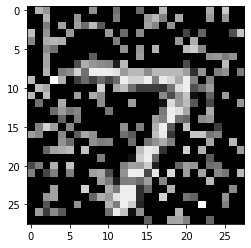

In [139]:
noise_level = 0.3
mnist_test_with_noise = inject_noise(data_test, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28), cmap="gray")

In [140]:
def get_accuracy_values_at_noise_level(
  data,
  targets,
  noise_level,
  dbn_model,
  n_layer,  # representation
  perceptron_model,
  ffnn_model
  ):

  noisy_data = inject_noise(data, noise_level)
  hidden_repr_noisy = get_layer_repr(data = noisy_data, dbn_model = dbn_model, n_layer = n_layer)

  predictions_perceptron = perceptron_model(hidden_repr_noisy)  

  predictions_ffnn = ffnn_model(noisy_data) #.reshape((noisy_data.shape[0], 784)))
  
  accuracy_perceptron = compute_accuracy(predictions_perceptron, targets)
  accuracy_ffnn = compute_accuracy(predictions_ffnn, targets)
  
  return accuracy_perceptron, accuracy_ffnn

In [141]:
get_accuracy_values_at_noise_level(
    data = data_test,
    targets = targets_test,
    noise_level = 0.2,
    dbn_model = model_deep.dbn_model,
    n_layer = 0,
    perceptron_model = model_deep.attached_perceptron,
    ffnn_model = ffnn
)

(0.886900007724762, 0.8176000118255615)

In [142]:
def plot_noise_robustness_curves(
  noise_levels,
  data,
  targets,
  dbn_model,
  n_layer,
  perceptron_model,
  ffnn_model
  ):
  accuracies_perceptron = []
  accuracies_ffnn = []
  
  for noise_level in noise_levels:
    accuracy_perceptron, accuracy_ffnn = get_accuracy_values_at_noise_level(
      data = data,
      targets = targets,
      noise_level = noise_level,
      dbn_model = dbn_model,
      n_layer = n_layer,
      perceptron_model = perceptron_model,
      ffnn_model = ffnn_model
  
    )
    accuracies_perceptron.append(accuracy_perceptron)
    accuracies_ffnn.append(accuracy_ffnn)
  
  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracies_perceptron)
  ax.plot(range(len(noise_levels)), accuracies_ffnn)
  
  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "FFNN"])

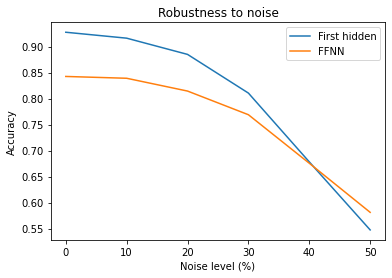

In [143]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5] #, 0.6, 0.7, 0.8]

plot_noise_robustness_curves(
    noise_levels = noise_levels,
    data = data_test,
    targets = targets_test,
    dbn_model = model_deep.dbn_model, 
    n_layer = 0,
    perceptron_model = model_deep.attached_perceptron,
    ffnn_model = ffnn
)

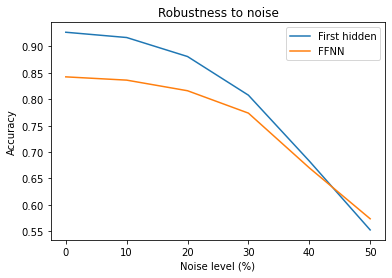

In [144]:
plot_noise_robustness_curves(
    noise_levels = noise_levels,
    data = data_test,
    targets = targets_test,
    dbn_model = model_shallow.dbn_model, 
    n_layer = 0,
    perceptron_model = model_shallow.attached_perceptron,
    ffnn_model = ffnn
)

# Adversarial attacks

In [145]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [146]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, perceptron):
        super().__init__()
        self.readout = perceptron
        self.dbn_mnist = dbn_mnist

    def forward(self, image):
        x, _ = self.dbn_mnist.forward(image)
        x = self.readout.forward(x)
        return x

In [148]:
dbn_with_readout = DBNWithReadOut(
    model_shallow.dbn_model, 
    perceptron = model_shallow.attached_perceptron
)

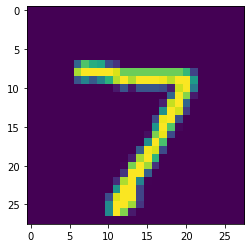

In [149]:
idx = 1
test_image = data_test[:idx].reshape(1, 28, 28)
__ = plt.imshow(test_image.reshape(28,28))

In [150]:
attacked_model = ffnn

test_label = targets_test[:idx]

test_image.requires_grad = True
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this sample is {prediction}.")

loss_value = torch.nn.functional.cross_entropy(model_outputs, test_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, 0.2, image_grad)

The prediction of the model for this sample is 7.


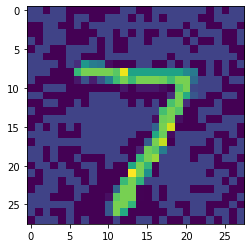

In [151]:
perturbed_image_np = perturbed_image.detach().numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [152]:
model_outputs = attacked_model(perturbed_image)
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 9.


## Robustness to adversarial attacks

In [153]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(1, 28, 28)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial predi ction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))

    return final_acc

In [154]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.MNIST('data/', train=False, download=False, transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True)

In [155]:
device = torch.device("cpu")

In [156]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 10000/10000 [00:15<00:00, 655.92it/s]


Epsilon: 0.1	Test Accuracy = 5458 / 10000 = 0.5458



In [157]:
final_acc = test_robustness_to_attack(
    dbn_with_readout,
    device,
    test_loader, 
    epsilon=0.1,
    num_steps=0
)

100%|██████████| 10000/10000 [00:10<00:00, 909.39it/s]


Epsilon: 0.1	Test Accuracy = 6447 / 10000 = 0.6447



  0%|          | 0/10000 [00:00<?, ?it/s]


Here's the original sample:



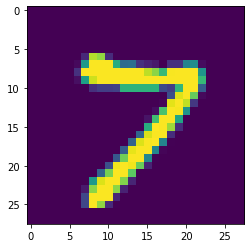


Here's a perturbed sample:



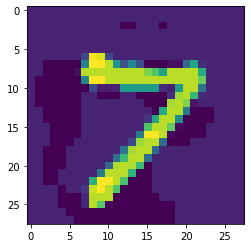


Here's what a 1-steps reconstructed sample looks like:



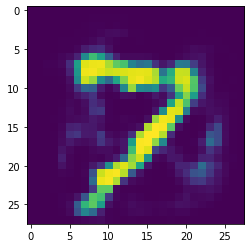

100%|██████████| 10000/10000 [00:14<00:00, 695.80it/s]


Epsilon: 0.1	Test Accuracy = 7608 / 10000 = 0.7608



In [163]:
final_acc = test_robustness_to_attack(
    dbn_with_readout, 
    device,
    test_loader, 
    epsilon = 0.1,
    num_steps = 1
)

## Effect of $\epsilon$

In [159]:
def test_epsilon_values_effect(epsilons, model, device, loader, n_steps):
  accuracies = list()

  for eps in epsilons:
      acc = test_robustness_to_attack(model, device, loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [160]:
epsilons = [0, 0.1, 0.2]  # [0, .05, .1, .15, .2, .25]
accuracies_ffnn = test_epsilon_values_effect(epsilons, ffnn, device, test_loader, n_steps=0)
accuracies_rbm_0 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps=0)
accuracies_rbm_1 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps = 1)
accuracies_rbm_2 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps = 2)

100%|██████████| 10000/10000 [00:20<00:00, 485.03it/s]


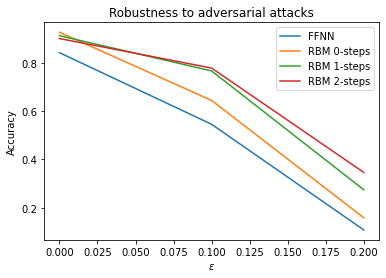

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

__ = ax.plot(epsilons, accuracies_ffnn)
__ = ax.plot(epsilons, accuracies_rbm_0)
__ = ax.plot(epsilons, accuracies_rbm_1)
__ = ax.plot(epsilons, accuracies_rbm_2)
__ = ax.set_xlabel("$\epsilon$")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks")
__ = ax.legend(["FFNN", "RBM 0-steps", "RBM 1-steps","RBM 2-steps"])

## Contacts

- 📧 flavio.petruzzellis@phd.unipd.it
- 💬 [Moodle forum](https://elearning.unipd.it/math/mod/forum/view.php?id=36439)